# Outline
We want to test the procedures below. This is written before actually testing anything, so after each step we keep the model that performed best. This is not about achieving state of the art, but rather about understanding the influence of each step.

1. Standard architecture roughly based on VGG: 3 sets of 2 filter stacks, each set followed by maxpooling. Finish with one fully connected layer with dropout and then output
2. Add image augmentation: (it wouldn't hurt to check the effect of each separately!)
    - ColorJitter
    - RandomHorizontalFlip
    - RandomRotation
    - RandomResizedCrop
3. Since it's not directly available in the torchvision transforms, investigate the effect of adding noise to the images, implemented as a lambda transform
4. Can we improve performance by adding another fully connected layer at the end?
5. What if we go the other way and instead of adding complexity (another layer) we simplify the model by replacing fully connected layers with global average pooling?
6. Weight initialization
7. Would batch normalization help? At the very least it should help us train faster. 
8. Would residual connections help despite the relatively shallow depth of our model?
9. Weight initialization.
10. Adding an extra output neuron. 

We will assess model performance using 50 epochs.

# Step 0: basic stuff

We load many functions and classes from misc.py.

In [1]:
# Import most things
# We will use the normalization of ImageNet models from misc.py which has norm_mean and norm_std
from misc import *

%load_ext autoreload
%autoreload 2
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# We will need a folder to save the trained models in
if not os.path.isdir("./trained/"):
    os.mkdir("./trained/")
# We will also need a temp folder
if not os.path.isdir("./temp/"):
    os.mkdir("./temp/")
    
# Set some stuff that won't change
image_folder = (os.getcwd() + "/dogImages/").replace('\\','/')
n_epochs = 100
batch_size = 64
depth_1 = 32 # depth of the first filter stack; it gets doubled after each maxpool
fc_size = 512 # size of the fully connected layer
p_dropout = 0.5 # probability of dropout
num_workers = 8 
img_short_side_resize = 256
img_input_size = 224

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))

CUDA is available!  Training on GPU ...
Using GeForce RTX 2070


# Step 1: Basic classification

### Finding an appropriate learning rate
Before we start we should be careful about the learning rate we choose. Too high and it will never converge. Too low and it will take too long. After a bit of experimentation I found a range that is worth testing. Note that for finding the learning rate we use data augmentation, otherwise the terrible overfitting (that you will soon see) will prevent us from drawing any conclusions. 

The goal of this part was not to achieve the best possible performance, or to investigate the influence of each augmentation method, but just to select an appropriate learning rate that we might use for the rest of the work.

In [3]:
learning_rates = [1e-4,2.5e-4,5e-4,7.5e-4,1e-3]
file_names = ["lr_1e_4.pt","lr_2_5e_4.pt","lr_5e_4.pt","lr_7_5e_4.pt","lr_1e_3.pt"]

try_learning_rates(learning_rates,file_names,image_folder,75,device)

Trying learning rate 1/5: lr = 0.0001
Trying learning rate 2/5: lr = 0.0003
Trying learning rate 3/5: lr = 0.0005
Trying learning rate 4/5: lr = 0.0008
Trying learning rate 5/5: lr = 0.0010


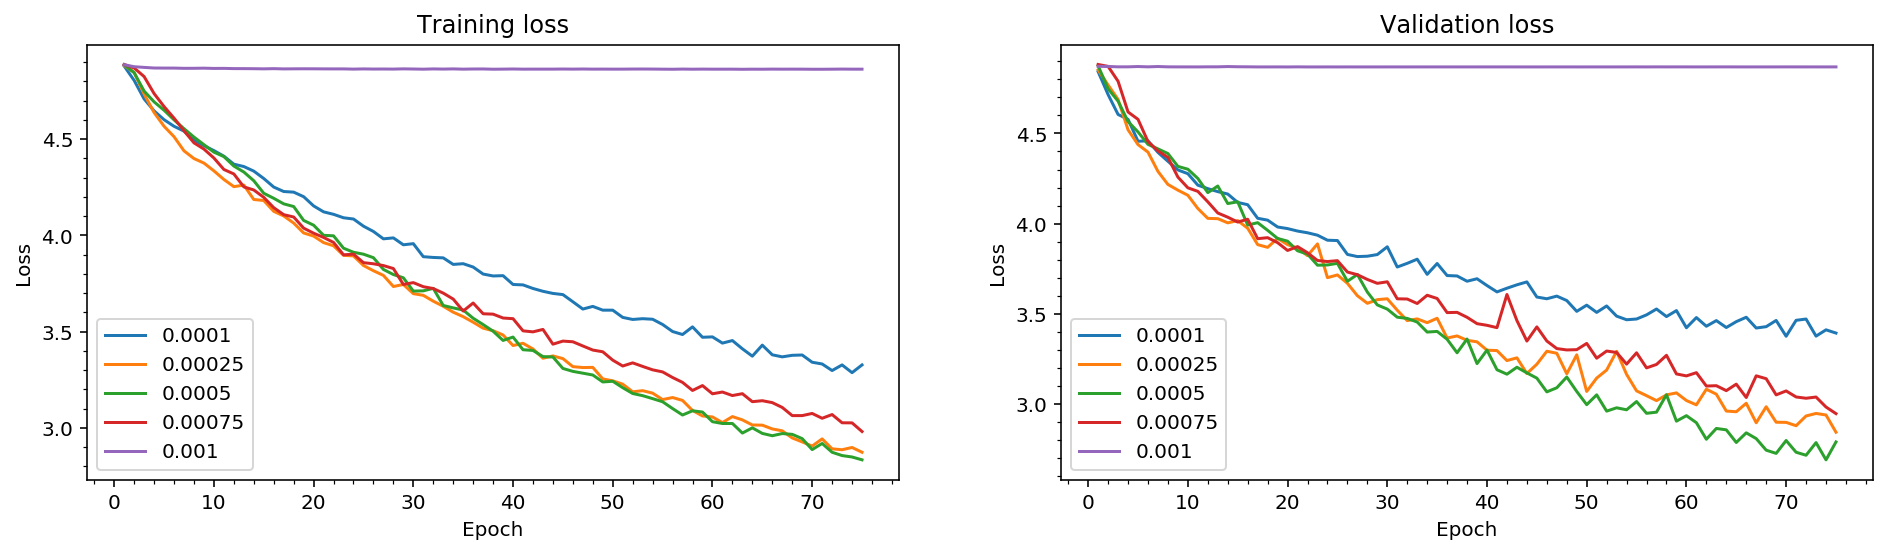

In [4]:
# Show how each learning rate performed
path_list = [f"./learning_rates/lr_1e_4.pt",
            f"./learning_rates/lr_2_5e_4.pt",
            f"./learning_rates/lr_5e_4.pt",
            f"./learning_rates/lr_7_5e_4.pt",
            f"./learning_rates/lr_1e_3.pt"]
model_names = ["Rescaling", "5crop - mean", "5crop - max"]
show_loss_many_models(path_list, model_names = learning_rates)

It looks like the optimum learning rate is 5e-4. It trains as fast as 2.5e-4 but has smaller validation loss as well as less variance in it. It's also interesting that training with 7.5e-4 is slower. Let's use 5e-4 for the rest of our experiments.

In [5]:
learning_rate = 5e-4

### Data loading

In [6]:
# Define the transform. Take care that because of the fully connected layers we need to have all images of the same size. 
# We don't want to crop only the center and potentially leave the dog's head out of the picture
# So let's simply rescale to a square image for now
transform_train = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, batch_size = batch_size, num_workers = num_workers)

### Architecture
Let's call this basic architecture **CNN+FC**. 

Let's train the model with no data augmentation to see how that works. 

Here we will train the model for only 20 epochs, which will be more than enough to prove a point. 

In [7]:
path_model = f"./trained/model_1_basic_{20}.pt"
# instantiate the CNN
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
# Larger learning rates lead nowhere apparently
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,20,device)

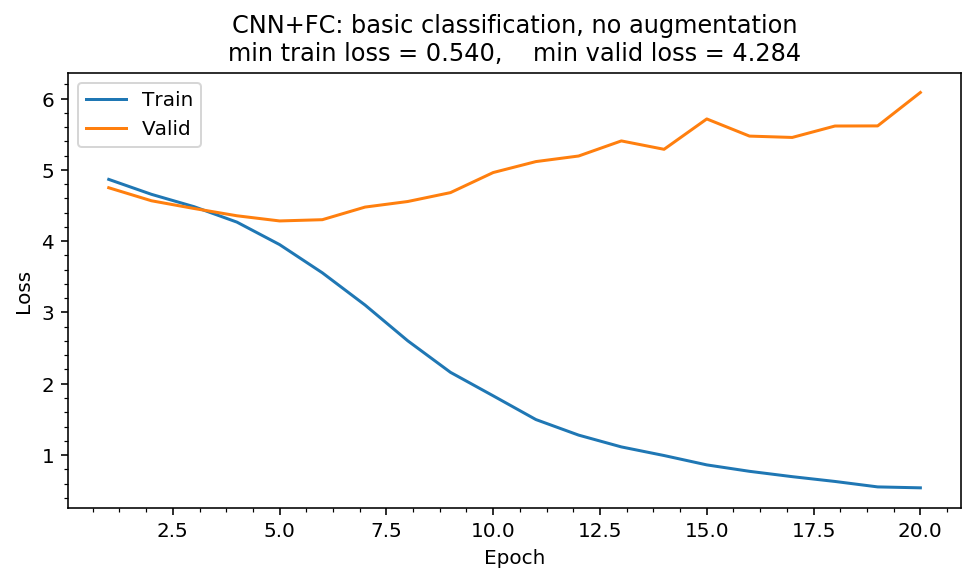

In [8]:
# Show training and validation loss for this model
show_loss_one_model(train_loss, valid_loss, 
                    f"CNN+FC: basic classification, no augmentation\n" + 
                    f"min train loss = {min(train_loss):.3f},    min valid loss = {min(valid_loss):.3f}")

## Step 2: Image augmentation
### Playing around with transforms
First try each transform separately to get an idea about the parameters. Then combine the transforms using Compose.

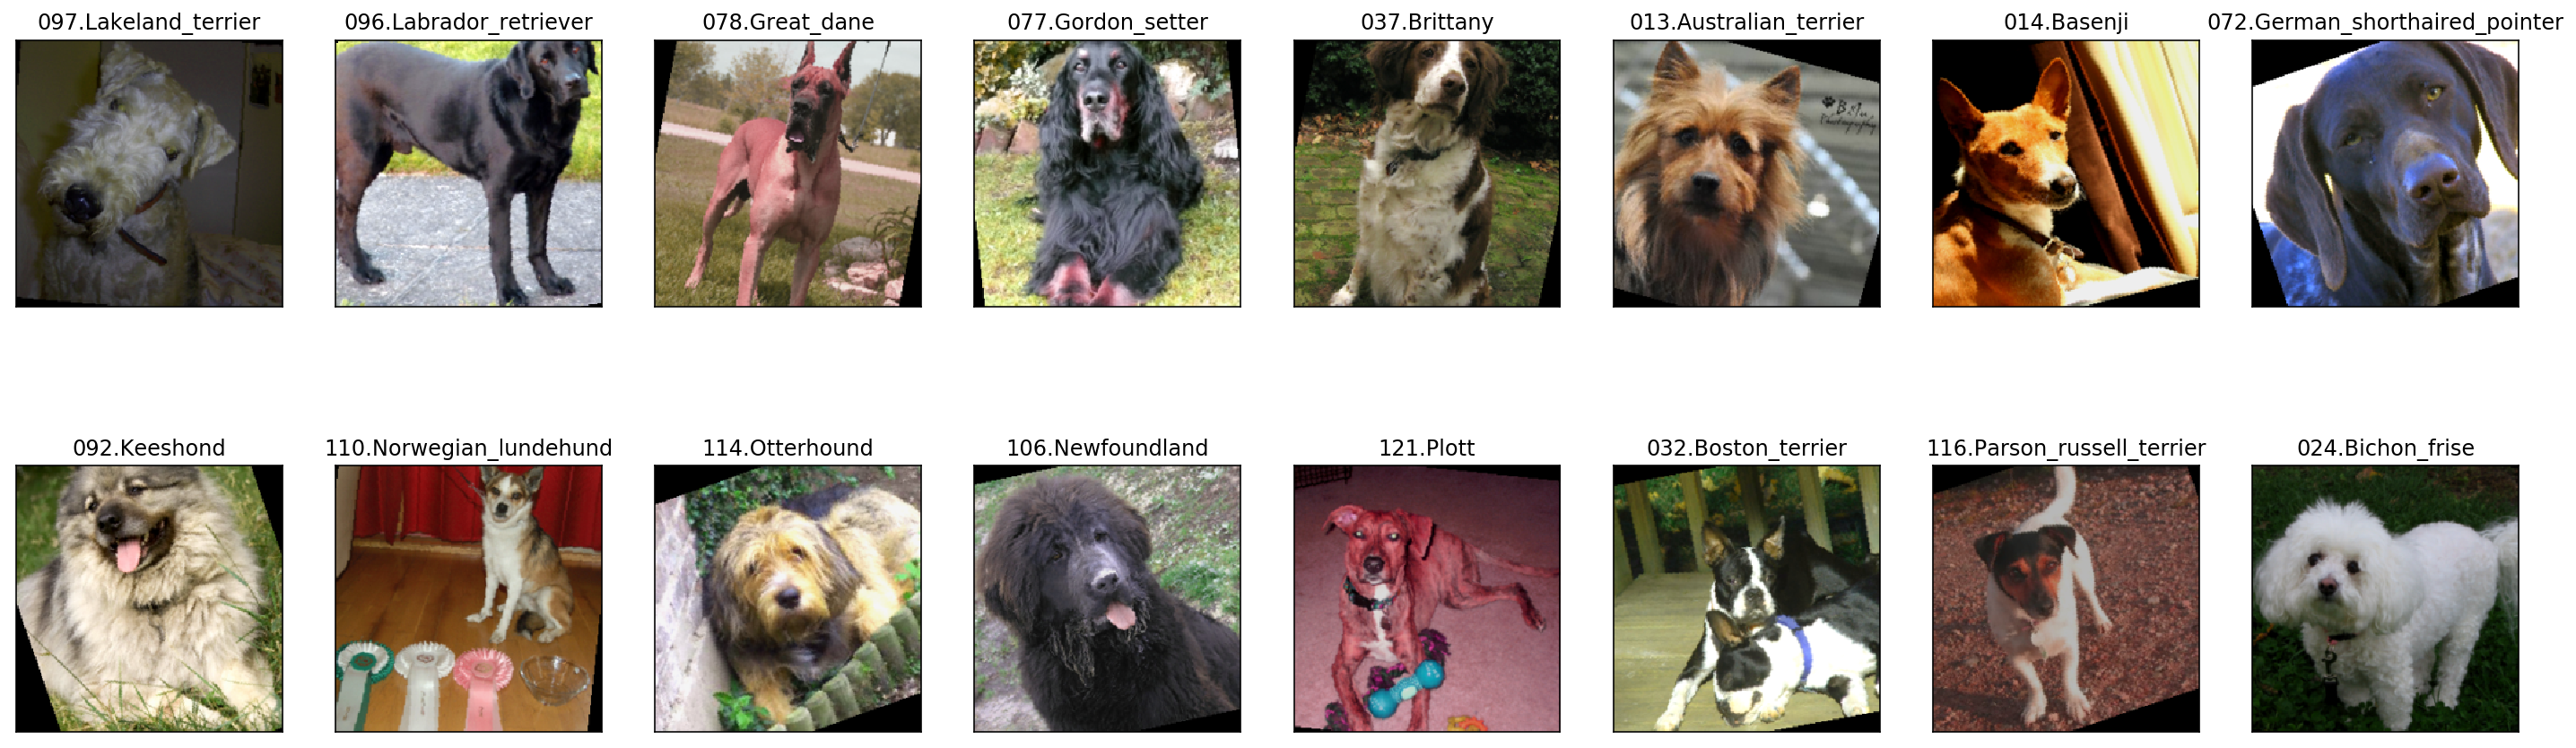

In [9]:
# The transform below is a satisfactory result for me after getting a feel of the parameter effects of each transform
transform = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),    
                    transforms.RandomRotation(20),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.7,1), ratio=(1,1)),    
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
show_batch(image_folder + "train/", transform = transform, shuffle = True)

##### Thoughts:
- Found out the hard way that resizing should be first, otherwise during training your CPU will have a hard time keeping up with the GPU while doing the color jitter on full resolution images.
- RandomHorizontalFlip and ColorJitter should clearly be there. The *horizontal* flip because our existence is more horizontal than vertical, therefore the pictures we take as well, and the color jitter because camera quality and white balance can differ.
- RandomResizedCrop
- Blurring would be nice. Would that help? **Investigate**
- Does rescaling images by changing the aspect ratio hurt performance? 
- On one hand if the scale of RandomResizedCrop is too small the dog's head might be omitted from the picture, which would probably hurt performance. On the other hand the dataset is very small so maybe a small scale would force the network to "look" at the details also and not only at the most obvious patterns. The default min scale is 0.08. Let's compare performance to the square. **Investigate**.
- One question is whether the black borders created by the rotation adversely impact performance. **Investigate**.

- For networks using fully connected layers images must always be the same size. While this is easy to achieve with RandomResizedCrop in training, we would actually like to use the entire image for inference. How do we manage this? There are a few possibilities that I can think of:
    - Rescaling the image to a certain size. This ruins the aspect ratio and dogs will appear stretched.
    - Using something like FiveCrop to get five square crops that cover the entire image. What do we do with the five predicted scores then? There are two methods that make sense:
        - Average them (Torchvision recommendation)
        - Take the maximum. I believe this might work better since it closely ties to the concept of max pooling where we want to find the maximum activation of a certain kind, irrespective of spatial location. The difference between **average** and **max** should be tested. **Investigate**.
    - Incorporate random rescaling into the training transform. The hope is that the network will become insensitive to rescaling and test time rescaling will not adversely impact performance. The property of rescale invariance does not appear to be beneficial though. Dogs in normal photographs will not be stretched, so this invariance would only be useful if our data contains rescaled images.
    - *Probably the best way to avoid this problem altogether is to use global average pooling instead of fully connected layers. This would create a vector that only depends on the number of filters and not on image size.* **This is super wrong**. The main reason why images need to be the same size is because we use mini batches.
    

### Let's check the influence of image augmentation like this:
- First we deal with the terrible overfitting we saw above. Perhaps some train set augmentation can help.
- Then we see if rescaling the image to another aspect ratio like we did before is a good idea or not. 
- Then add rotation to determine if there's any impact of the black borders for this application

#### 1. Data augmentation for preventing overfitting
One thing is clear from the first model we trained. It overfits like crazy and dropout is not enough to stop that. There's no point in comparing performances of such underachieving models. So let's see if augmenting the train set can improve things. We could try color jitter and horizontal flip.

Soiler alert, it's not quite enough. It's not at all enough, the model still overfits quite badly. 

So let's do some random cropping from the rescaled image and keep our test transform the same. So we keep rescaling training images to squares but we just add resized (square) crops from those images. Let's also investigate if a small scale is beneficial or not for this dataset.

Looking at the first few epochs, it's already a good sign that the training loss is higher than the validation loss. 

###### Large crops

In [10]:
# Add data augmentation but keep the potentially ridiculous rescaling in order to compare it to square cropping later.
transform_train = transforms.Compose([
                    transforms.Resize((img_short_side_resize,img_short_side_resize)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.7,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, batch_size = batch_size, num_workers = num_workers)

In [11]:
path_model = f"./trained/model_2_aug_large_crops_rescale_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,n_epochs,device)

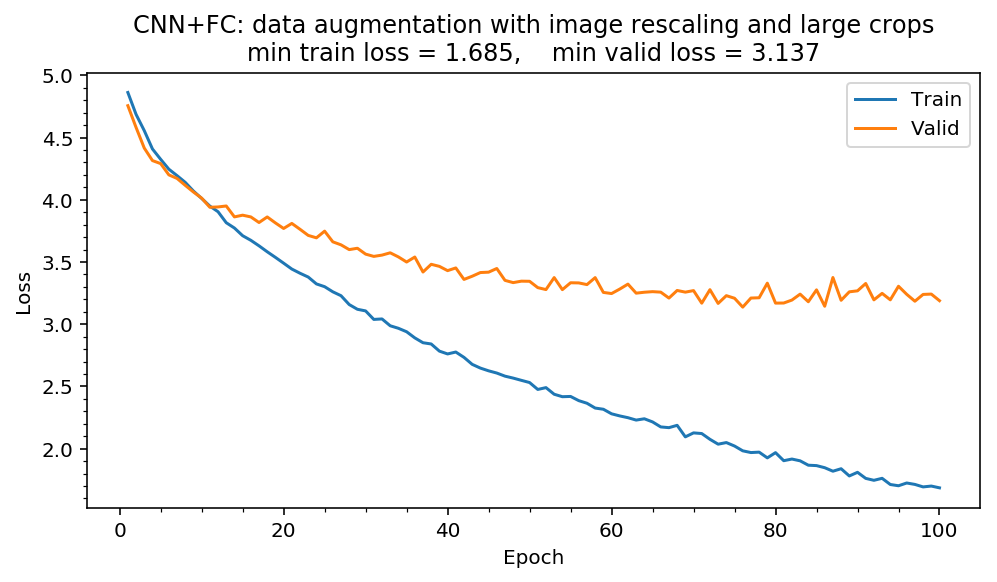

In [12]:
# Show training and validation loss for this model
show_loss_one_model(train_loss, valid_loss, 
                    f"CNN+FC: data augmentation with image rescaling and large crops\n" + 
                    f"min train loss = {min(train_loss):.3f},    min valid loss = {min(valid_loss):.3f}")

We see that after epoch 15 or so the validation loss stops decreasing and completely diverges from the training loss. This is not a good sign for our large crops approach. It looks like the dataset is not augmented enough and the model still overfits. Let's see if using small crops works better. 

###### Small crops

In [13]:
# Add data augmentation but keep the potentially ridiculous rescaling in order to compare it to square cropping later.
transform_train = transforms.Compose([
                    transforms.Resize((img_short_side_resize,img_short_side_resize)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize((img_input_size,img_input_size)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, batch_size = batch_size, num_workers = num_workers)

In [14]:
path_model = f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,n_epochs,device)

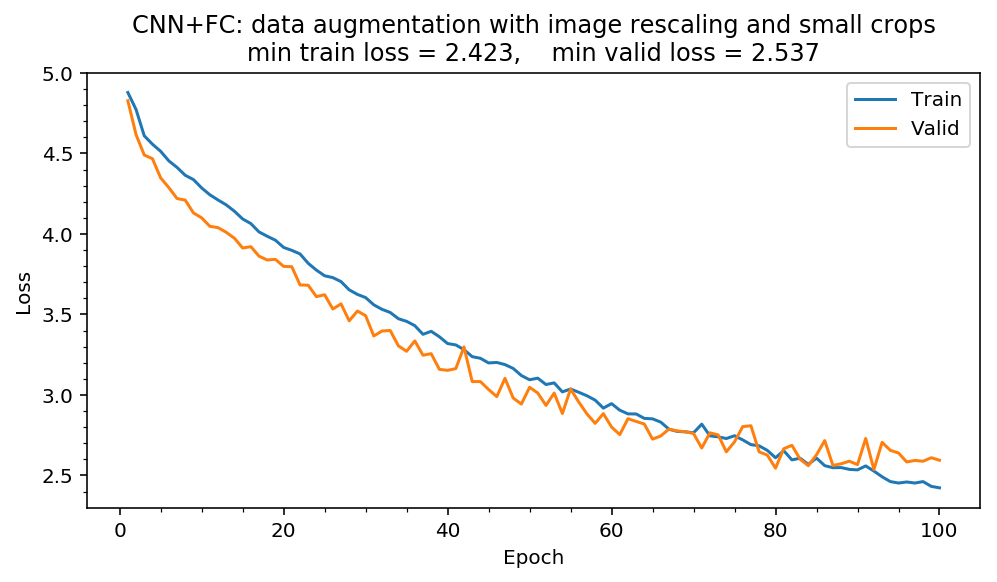

In [15]:
# Show training and validation loss for this model
show_loss_one_model(train_loss, valid_loss, 
                    f"CNN+FC: data augmentation with image rescaling and small crops\n" + 
                    f"min train loss = {min(train_loss):.3f},    min valid loss = {min(valid_loss):.3f}")

Wow, now that's something else! Looks like I was completely wrong about the dog's head having to be in the picture. I suppose it figures since I'm not very good at distinguishing dog breeds :) 

Let's see the two approaches side by side.

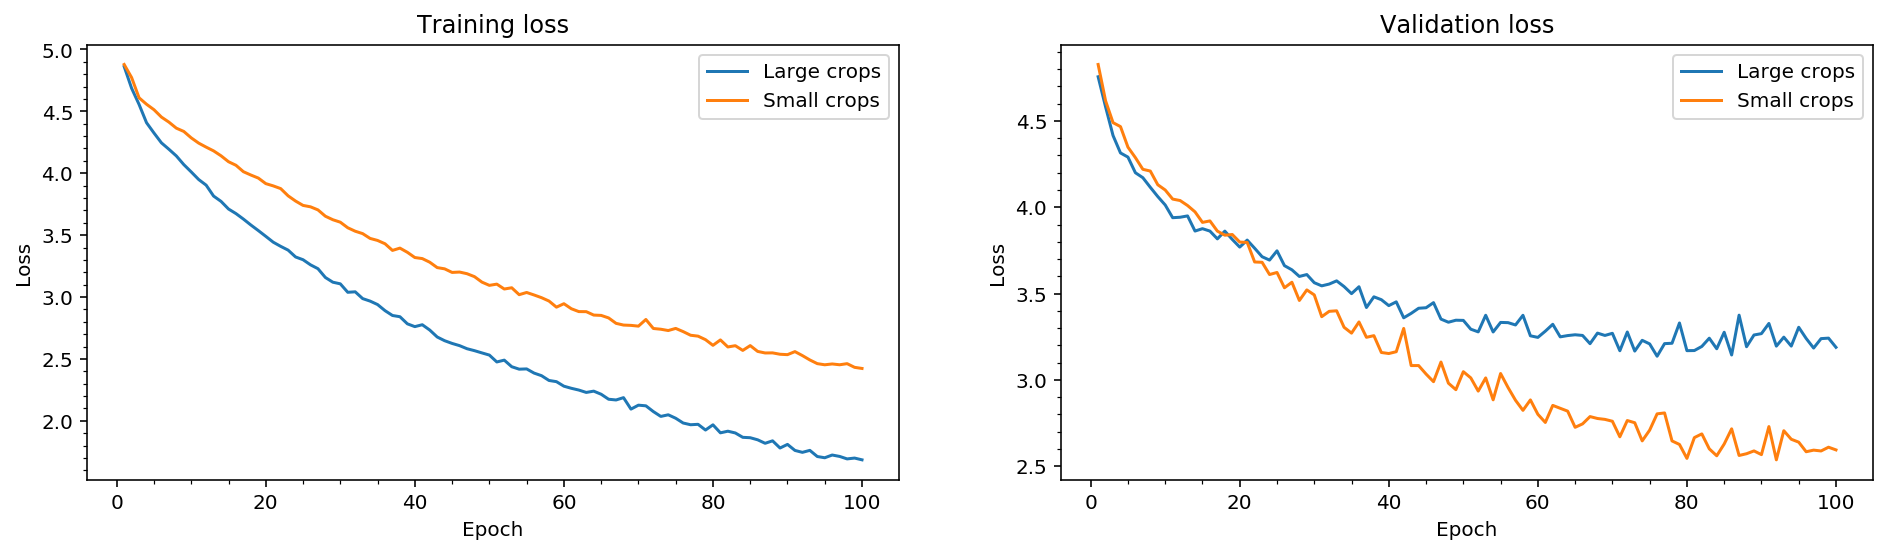

In [16]:
path_list = [f"./trained/model_2_aug_large_crops_rescale_{n_epochs}.pt",
           f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt"]
model_names = ["Large crops", "Small crops"]
show_loss_many_models(path_list, model_names = model_names)

So what I think happened here is that the network learnt to use as much information as possible, and not just the obvious hints such as ear and snout shape (or uhm... whatever the most relevant features are). Going for potentially very small crops and resizing them probably has another advantage as well: it's basically equivalent to blurring the input, which might make the network more robust to photo quality differences or improper focus. All in all, the small crops approach vastly outperforms the large crops one. This really goes to show that while convolutional nets seem intuitive we should always test the influence of parameters rather than relying solely on our intuition. 

This also shows why training for a large number of epochs (especially with aggressive augmentation) is important: training just 20 epochs or so would have given us the false impression that the large crops approach is better.

#### 2. Image rescaling VS cropping
So finally we can find out what is better, changing the aspect ratio and potentially distorting the images or cropping? In the previous section we used square crops from a stretched image, so we tested the rescaling approach. Now let's keep the original aspect ratio and see if that's better or worse. 

At test time we don't want random crops from the test image, so we will use the __[FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html)__ transform which splits the image into the center crop and the corners, hopefully with a healthy amount of overlap. 

In [17]:
# Add data augmentation but keep the potentially ridiculous rescaling in order to compare it to cropping later.
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

#### Five crop with mean (as recommended in __[docs](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)__)

In [18]:
path_model = f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Five crop with max

In [19]:
path_model = f"./trained/model_2_aug_small_crops_5crop_max_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "max")

#### Compare both with the rescale approach

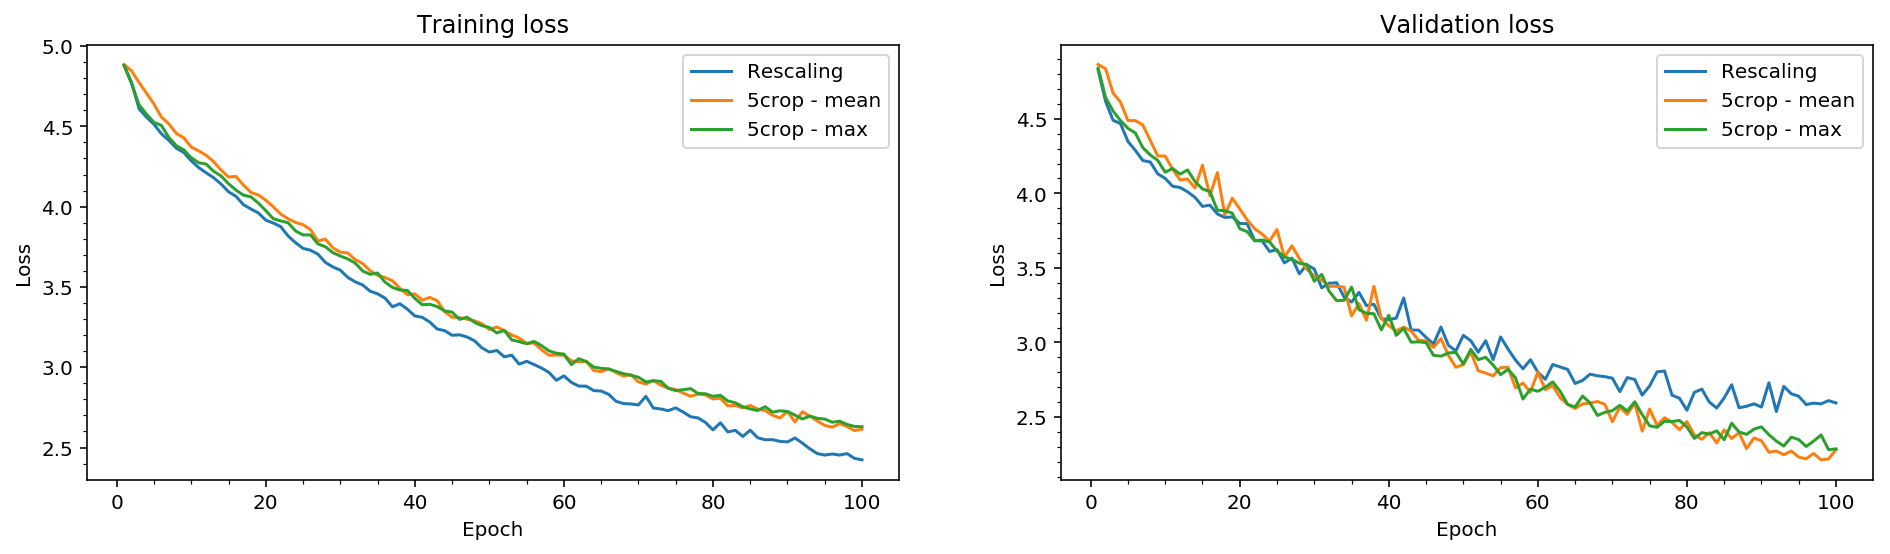

In [20]:
path_list = [f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt",
            f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_2_aug_small_crops_5crop_max_{n_epochs}.pt"]
model_names = ["Rescaling", "5crop - mean", "5crop - max"]
show_loss_many_models(path_list, model_names = model_names)

From the plot above we can see that the validation loss for the rescaling method does seem to plateau from around 60 epochs onward. Furthermore it looks more noisy compared to 5crop, which suggests that 5 crop for inference (or maybe test time augmentation in general?) is the way to go. But is the improvement due to test time inference or keeping the aspect ratio?

Since there's no difference between the mean and max methods I'll keep the Pytorch recommendation and stick to the mean. 

What is interesting is that the rescaling method trains faster while having very competitive validation loss. This begs the question, what happens if we include the rescaling in the training for the 5crop method? This would mean to leave the aspect ratio of the photo unchanged, extract our crops of various sizes, but also change their aspect ratio. Then we test with 5crop. 

In [21]:
# Add aspect ratio stretching in RandomResizedCrop. PyTorch recommendations were pretty good before, let's try them. 
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(3/4,4/3)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [22]:
path_model = f"./trained/model_2_aug_rescale_5crop_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Compare with normal rescaling and 5crop without rescaling

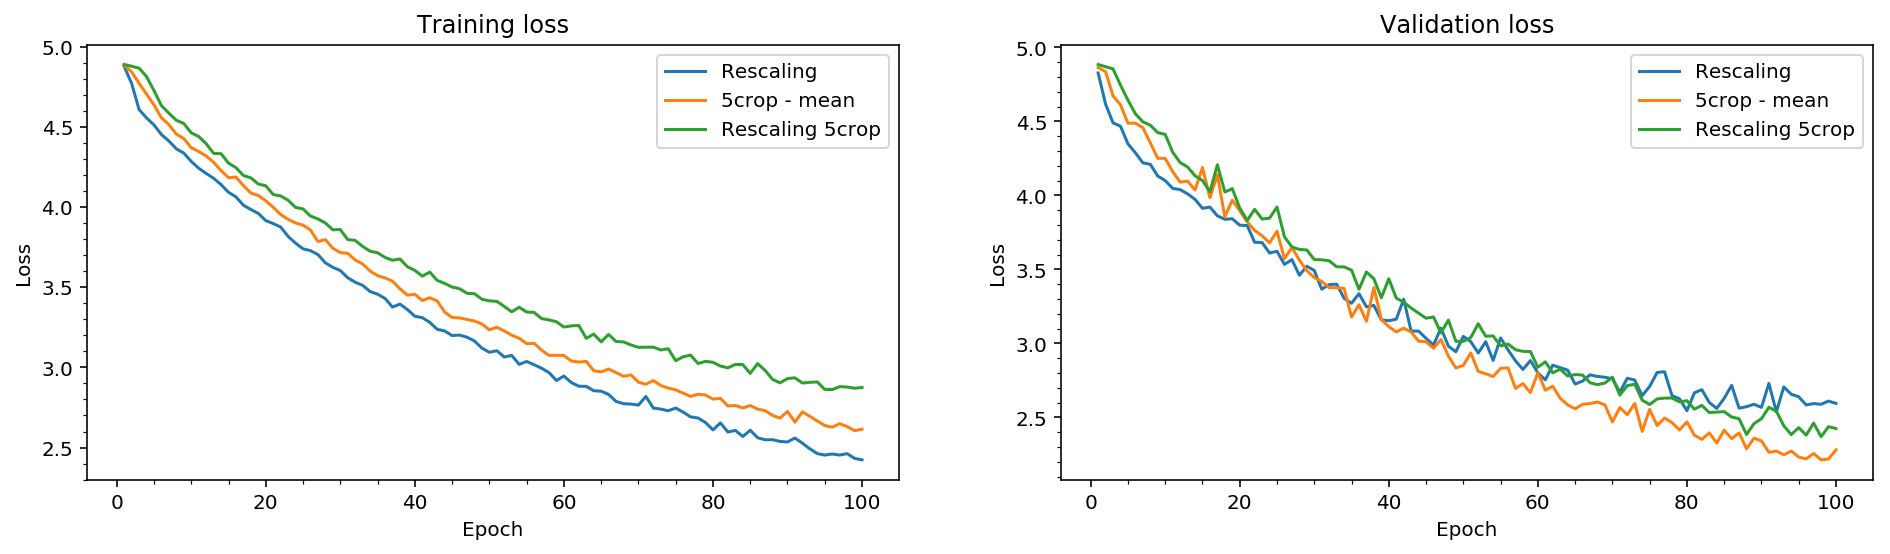

In [23]:
path_list = [f"./trained/model_2_aug_small_crops_rescale_{n_epochs}.pt",
            f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_2_aug_rescale_5crop_{n_epochs}.pt"]
model_names = ["Rescaling", "5crop - mean", "Rescaling 5crop"]
show_loss_many_models(path_list, model_names = model_names)

So we see that slight stretching of the aspect ratio does not bring any improvement. The model trains slower and the validation loss is higher. We will not stretch the aspect ratio from now on. 

#### Introducing rotations

In [24]:
# Add rotation.
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),   
                    transforms.RandomRotation(20),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [25]:
path_model = f"./trained/model_2_aug_5crop_rot_{n_epochs}.pt"
from misc import Net_Basic # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Basic(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Compare with previous results

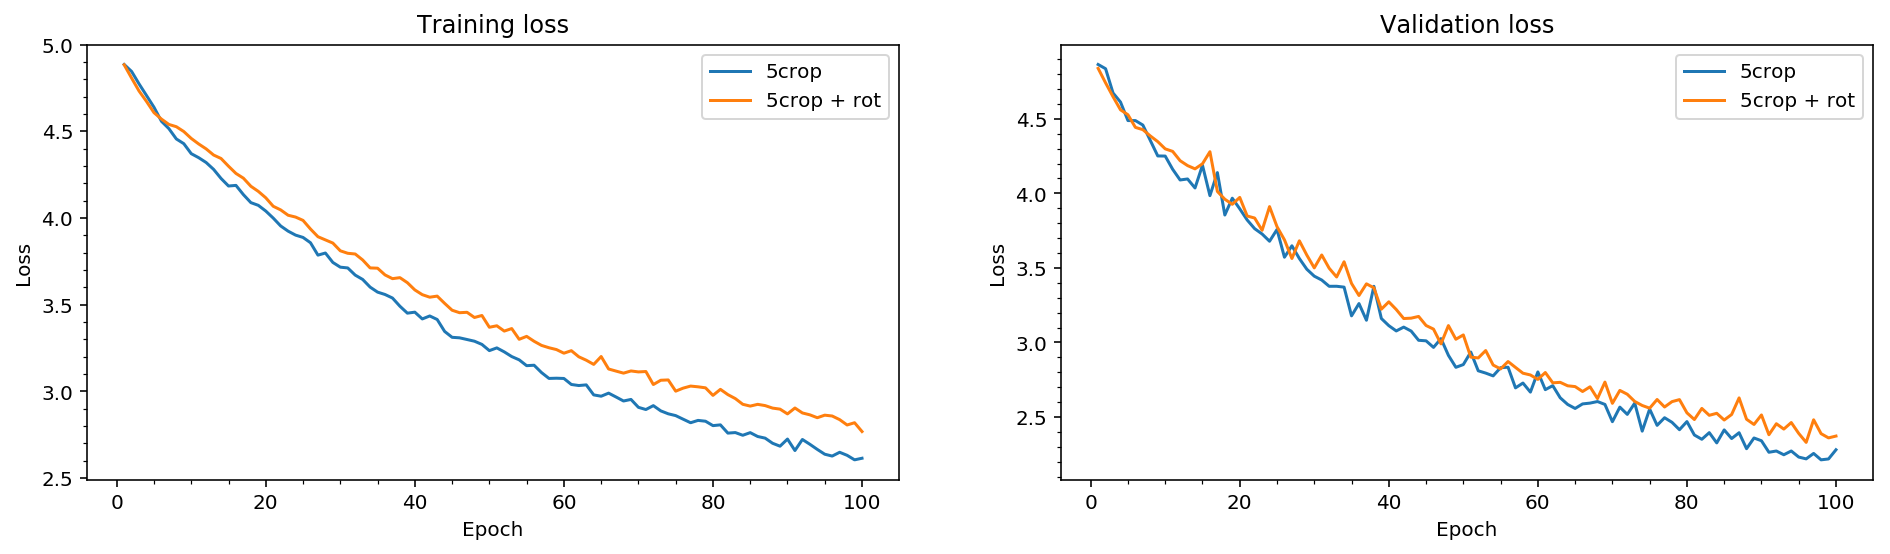

In [26]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_2_aug_5crop_rot_{n_epochs}.pt"]
model_names = ["5crop", "5crop + rot"]
show_loss_many_models(path_list, model_names = model_names)

We see that introducing rotations also makes the model train slower and produces a higher validation loss. We will not use rotations any further.

# Step 4: Adding complexity
### Adding another fully connected layer with dropout

In [27]:
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [28]:
path_model = f"./trained/model_3_2fc_{n_epochs}.pt"
from misc import Net_2FC # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_2FC(n_classes, depth_1 = depth_1, fc_size = fc_size, p_dropout = p_dropout, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

#### Compare with previous results

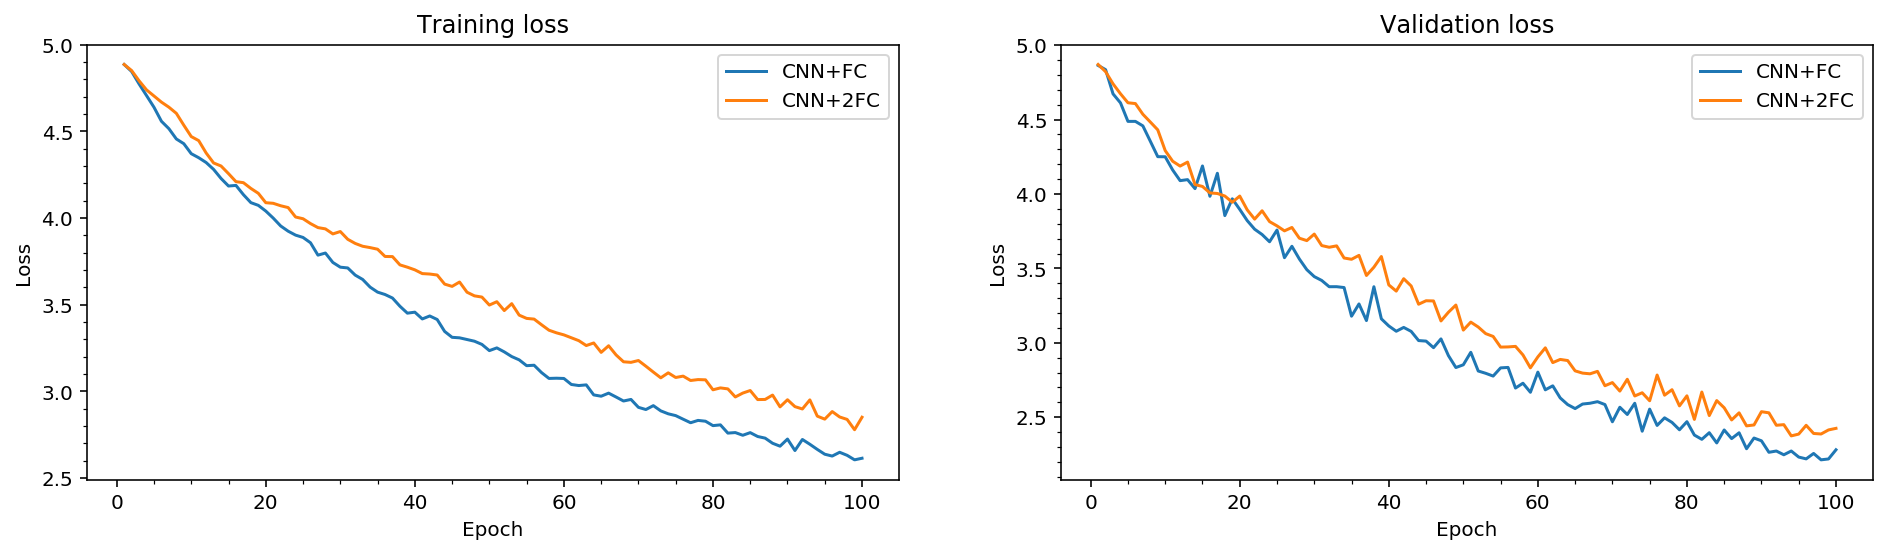

In [29]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
            f"./trained/model_3_2fc_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN+2FC"]
show_loss_many_models(path_list, model_names = model_names)

Adding another fully connected layer doesn't seem to do much. Let's try going the other way.

# Step 5: Reducing complexity
### Global average pooling
So global average pooling basically means this:
1. Take the average of your last conv layers **(with ReLU?)** per slice (so dimensions 2 and 3).
2. Flatten it.
3. After it insert a fully connected layer with n_classes neurons. Everybody talks about softmax here but that's not the point, it depends on which loss you're using. Our nn.CrossEntropyLoss() combines nn.LogSoftmax() and nn.NLLLoss() in one single class (__[doc](https://pytorch.org/docs/stable/nn.html#crossentropyloss)__).

Sounds pretty good. We're reducing complexity by a huge factor by eliminating the fully conected layer, since each neuron in the FC layer is connected to each neuron from the conv set! 

My problem though is with step 1. Why take the mean? It feels like it's going against conv net principles of detecting a patter of interest no matter where it is in the picture. Sure, we have activation functions so we'll take a mean of all the "detections". But is that really the best way? Or what if we could make it more expressive? 

Let's try these ideas, without reading any of the research! Let's test our intuition. 

So without further ado, my ideas for improving / replacing the global pooling:
1. **Max**: Take the max instead of the mean. This is more in line with the philosophy of neural nets. The normal max pooling layers are used instead of averaging because in this task we want to know whether a pattern is present or not irrespective of location. Dilluting that information with zeroes or low activations is conceptually not useful. 
2. **Threshold**: Go in-between and take the mean of the largest elements. Something like the ones that are further than 2 standard deviations from the slice mean.
3. **Linear**: Make it more expressive by describing more of the data, such as (mean, standard deviation, minimum, and maximum). Then we feed these into a neuron to come up with a linear transform for each slice. Then to the n_classes output.
4. **Non-linear single**: We add a ReLU to each of those neurons. 
5. **Non-linear multi**: We concatenate the vectors from step 3 from all slices and use that as input to a small fully connected network. There will still be a considerable decrease in the number of parameters. 
I think that the normal way of flattening all filters and feeding that to MLPs is wrong. Each hidden neuron would then be connected to each activation in all filters, irrespective of spatial location. What the neuron really wants is a large input that basically says "pattern detected". But when it has thousands of useful inputs, how can it weigh them? How would we weigh them? Maybe assign more weight to the ones in the center? That defeats the purpose of our task of detecting a pattern wherever it might be. Would we give equal weight to all? It certainly seems like a complicated problem and a simple solution is to create location-invariant features that describe each slice and use those as input to a hidden layer and then output. MLPs are great for tabular data, not so much for our task. That's why they work great on MNIST but if you "augment" your input with some translation they become useless. Let's help them out then. 

The problem is that for steps 3 and 4 we would need to either write a custom module for specifying connections or have depth_3 tiny linear layers with 4 inputs and one output. So let's directly kick it up a notch and implement idea 5, the non-linear multi. 

In [30]:
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = batch_size, num_workers = num_workers, fivecrop = True)

In [31]:
path_model = f"./trained/model_3_pooling_mean_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "mean", p_dropout = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

C:\Users\Mircea\Anaconda3\envs\dl\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'misc.Net_Pool' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [32]:
path_model = f"./trained/model_3_pooling_max_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "max", p_dropout = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

In [33]:
path_model = f"./trained/model_3_pooling_thresh_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "thresh", p_dropout = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

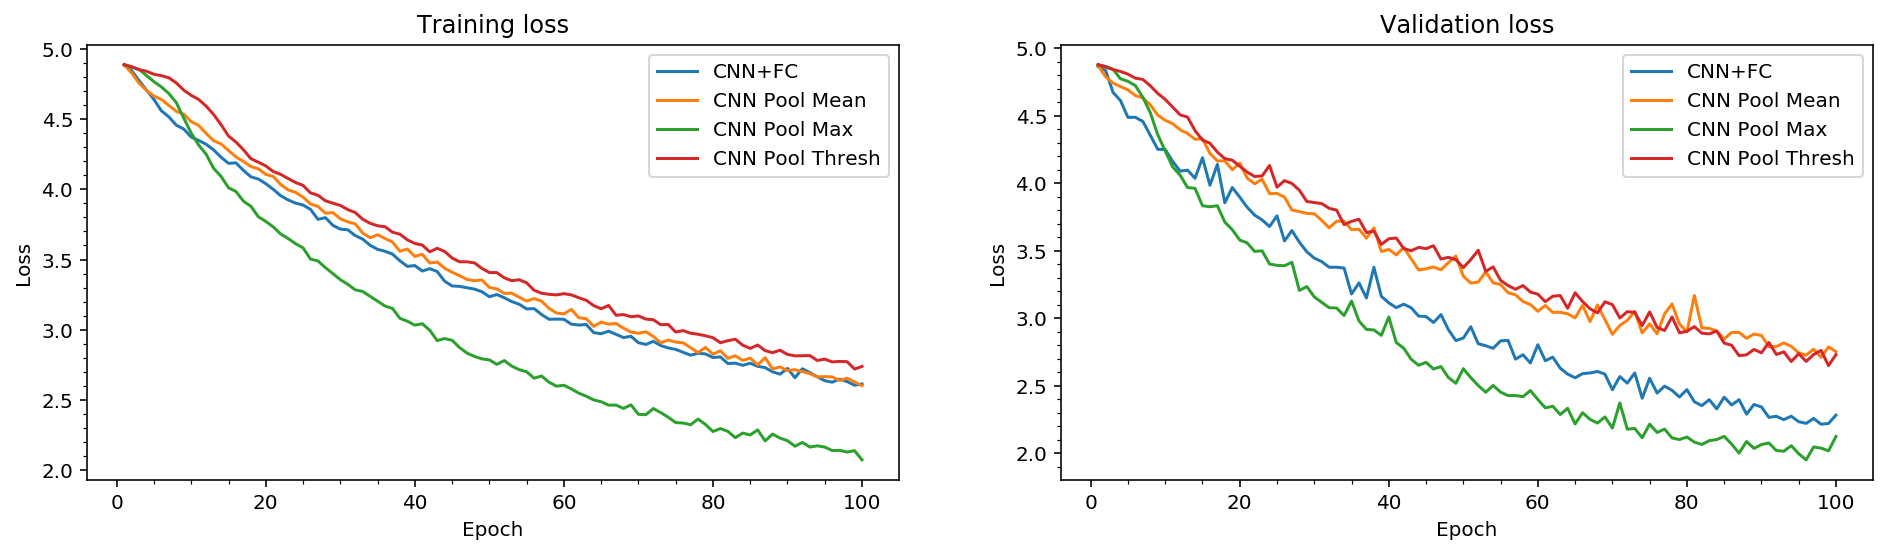

In [34]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_mean_{n_epochs}.pt",
            f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_3_pooling_thresh_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Mean","CNN Pool Max","CNN Pool Thresh"]
show_loss_many_models(path_list, model_names = model_names)



The max is apparently much better. Why do the popular architectures use mean then? 

Let's now test the non-linear multi method. 

In [35]:
path_model = f"./trained/model_3_pooling_nonlin_multi_1_layer_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "non-linear multi", extra_layer = False, p_dropout = 0,
                 p_dropout_pool = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

In [36]:
path_model = f"./trained/model_3_pooling_nonlin_multi_2_layers_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "non-linear multi", extra_layer = True, p_dropout = 0,
                 p_dropout_pool = 0, img_input_size = img_input_size)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

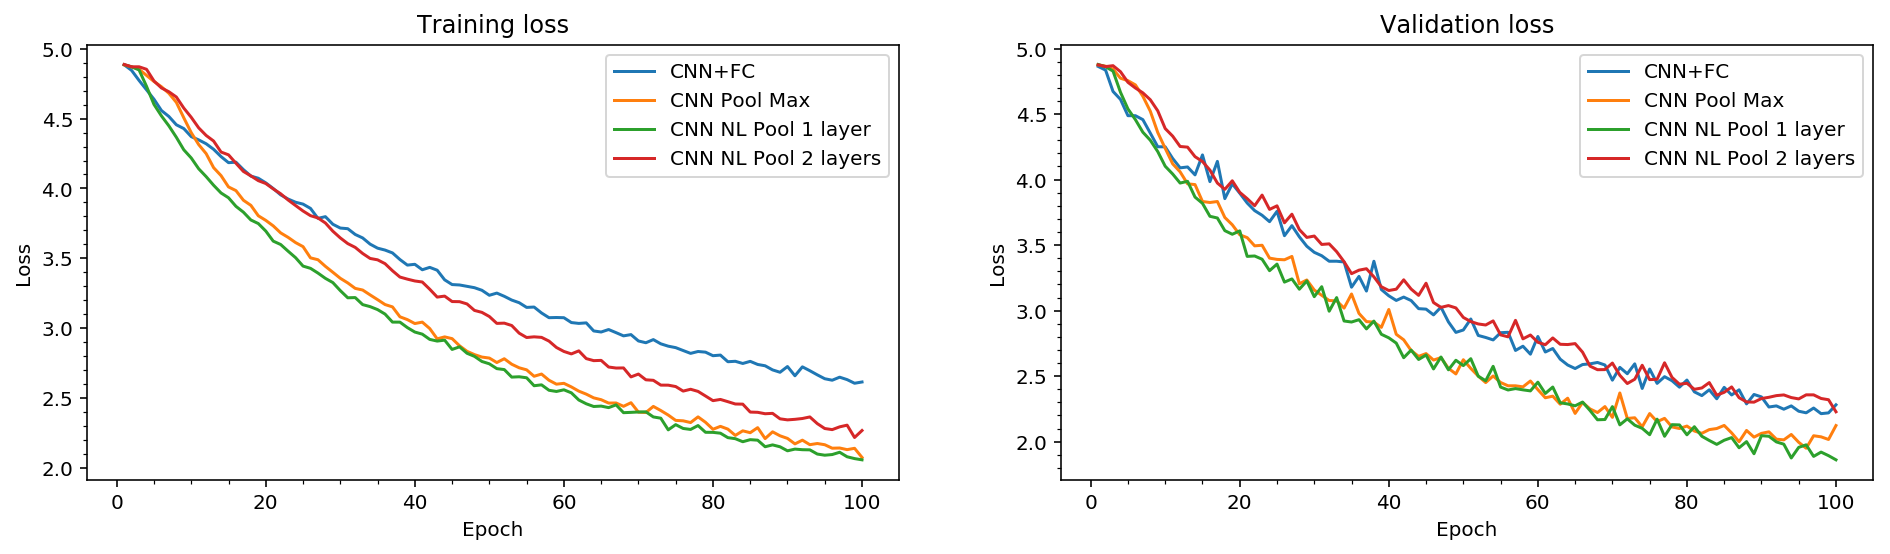

In [37]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_3_pooling_nonlin_multi_1_layer_{n_epochs}.pt",
            f"./trained/model_3_pooling_nonlin_multi_2_layers_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN NL Pool 1 layer","CNN NL Pool 2 layers"]
show_loss_many_models(path_list, model_names = model_names)



Adding more complexity to the global pooling does not seem to improve things. The max seems to be the best way to go so far

# Step 6: Weight initialization
Let's give the network the best chance by initializing the weights according to __[this paper](https://arxiv.org/abs/1502.01852)__.

In [38]:
path_model = f"./trained/model_4_weight_init_{n_epochs}.pt"
from misc import Net_Pool # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_Pool(n_classes, depth_1 = depth_1, pool_type = "max", extra_layer = False, p_dropout = 0,
                 p_dropout_pool = 0, img_input_size = img_input_size, weight_init = True)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

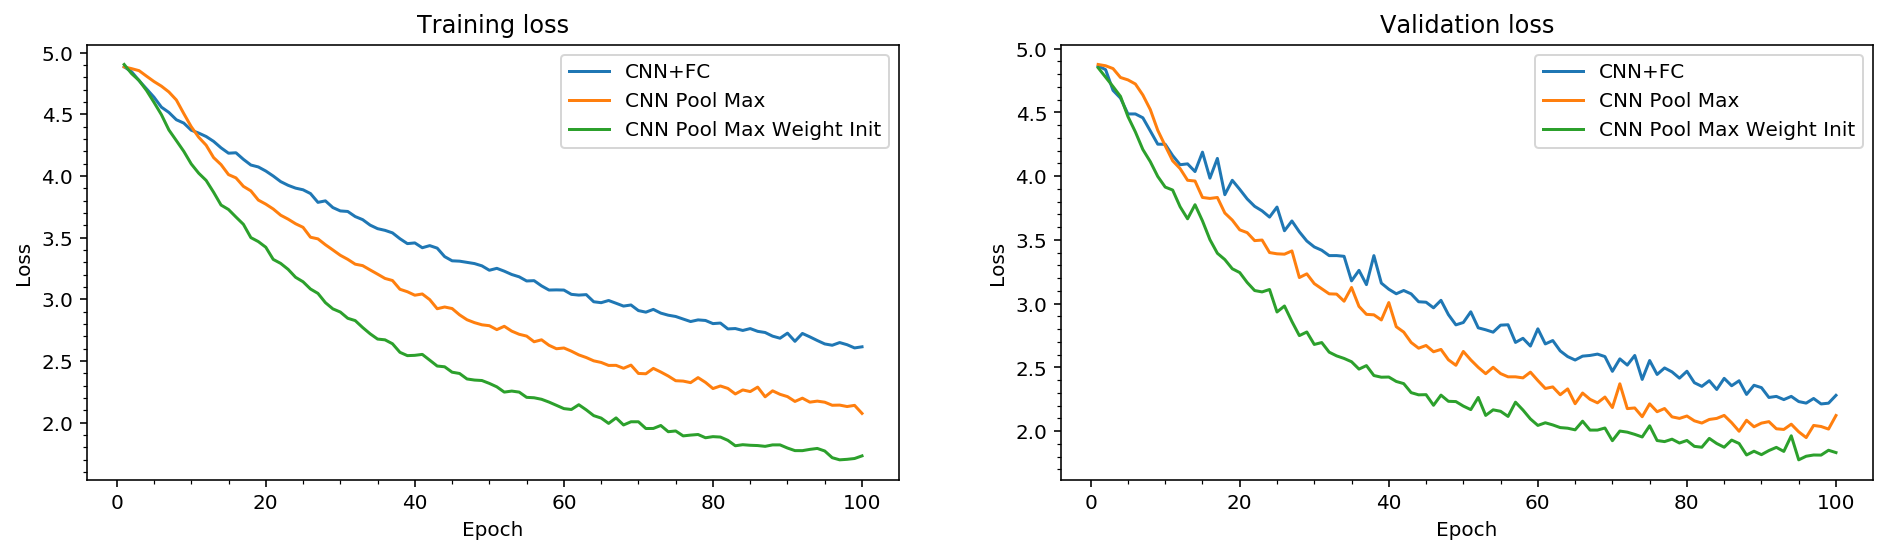

In [39]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN Pool Max Weight Init"]
show_loss_many_models(path_list, model_names = model_names)

# Step 7: Batch normalization
__[Batch normalization](https://arxiv.org/abs/1502.03167)__ is a powerful technique that helps the network learn faster. The authors achieved great results by increasing the learning rate 30x. Let's try that.

In [40]:
path_model = f"./trained/model_5_bn_{n_epochs}.pt"
from misc import Net_BN # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_BN(n_classes, depth_1 = depth_1)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean")

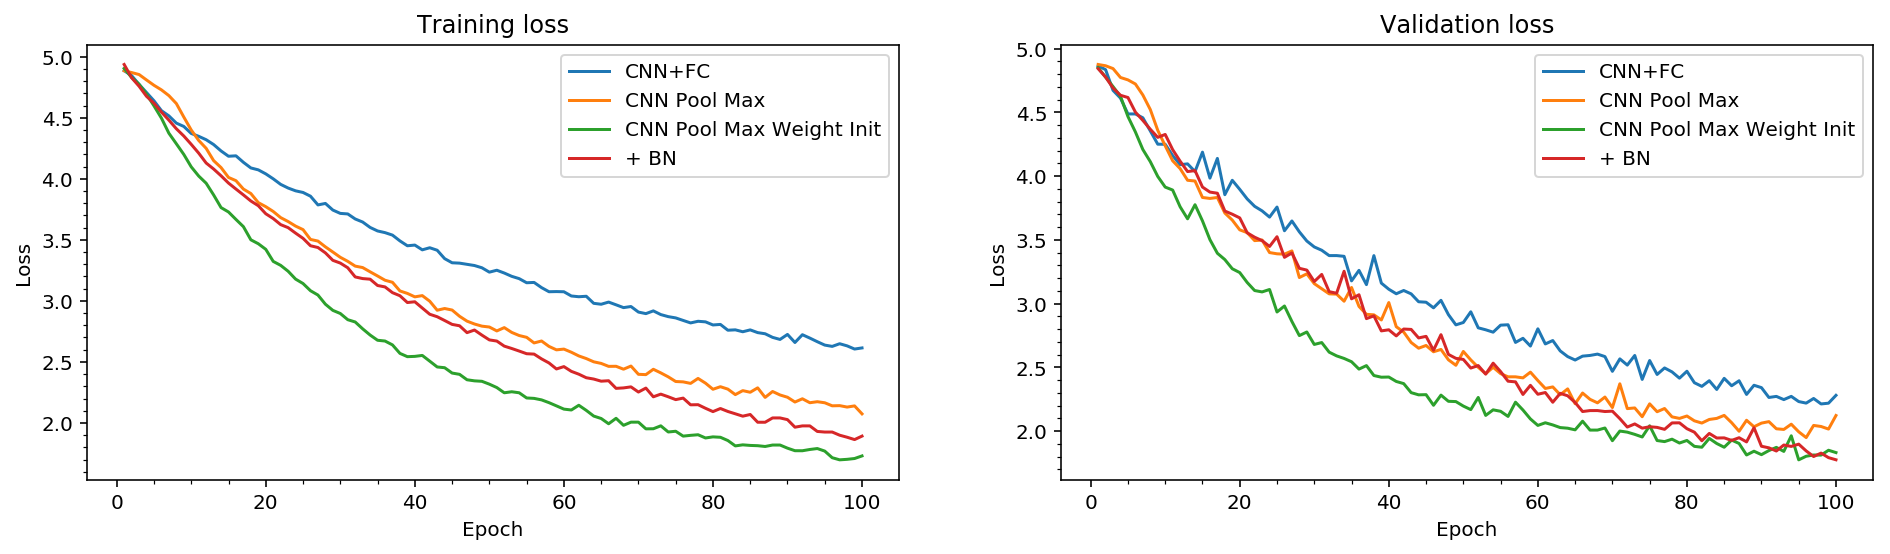

In [41]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt",
            f"./trained/model_5_bn_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN Pool Max Weight Init","+ BN"]
show_loss_many_models(path_list, model_names = model_names)



What we see above is that adding batch normalization makes the validation loss decrease more linearly, and likely plateau after a larger number of epochs. Training more is one option, but the biggest advantage of batch norm is that larger learning rates can be used. The authors of the original __[paper](https://arxiv.org/abs/1502.03167)__ managed to increase the learning rate 30 times without ill effects on performance. Below we therefore test 9 different learning rates, from our initial 5e-4 to one approximately 30 times higher. 

There is a catch though. Having too large of a learning rate in the later parts of training can make the optimizer miss the minimum completely and even diverge. We therefore implement a __[learning rate scheduler](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)__ that decreases the learning rate by a factor of 10 if the validation loss does not decrease after a maximum of 10 epochs. 

In [42]:
learning_rates = learning_rate * np.logspace(0,1.5,9)
learning_rate_strings = []
path_list = []
for i in range(len(learning_rates)):
    path_list.append(f"./learning_rates/bn_lr_{learning_rates[i]:.4f}.pt")
    learning_rate_strings.append(f"{learning_rates[i]:.4f}")
try_learning_rates_bn(learning_rates,path_list,image_folder,100,device)

Trying learning rate 1/9: lr = 0.0005
Trying learning rate 2/9: lr = 0.0008
Trying learning rate 3/9: lr = 0.0012
Trying learning rate 4/9: lr = 0.0018
Trying learning rate 5/9: lr = 0.0028
Trying learning rate 6/9: lr = 0.0043
Trying learning rate 7/9: lr = 0.0067
Trying learning rate 8/9: lr = 0.0103
Trying learning rate 9/9: lr = 0.0158


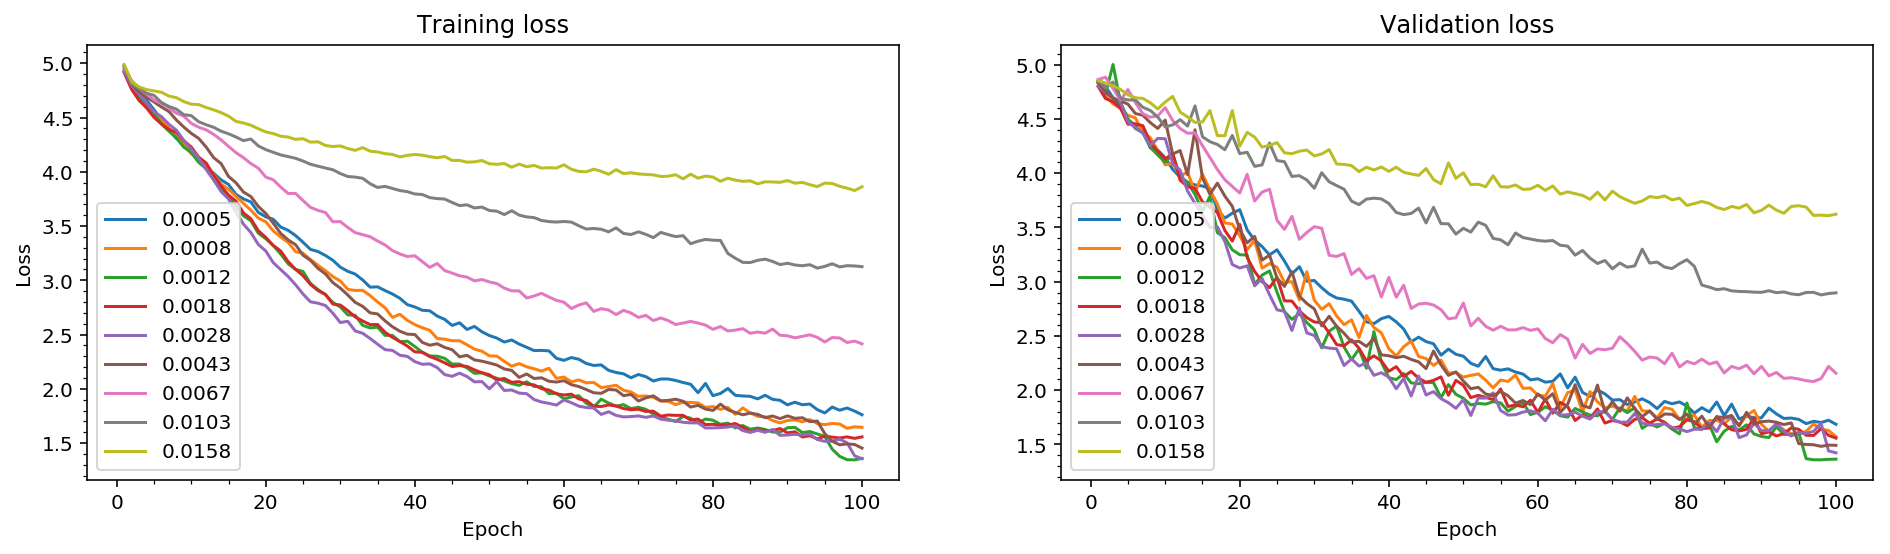

In [43]:
# Show how each learning rate performed
show_loss_many_models(path_list, model_names = learning_rate_strings)

The learning rate of 0.0012 performed best. We can clearly see the learning rate scheduler reducing the learning rate around epoch 94. Let's copy the file "./learning_rates/bn_lr_0.0012.pt" to "./trained/", rename it, and compare this performance to our previous approaches.

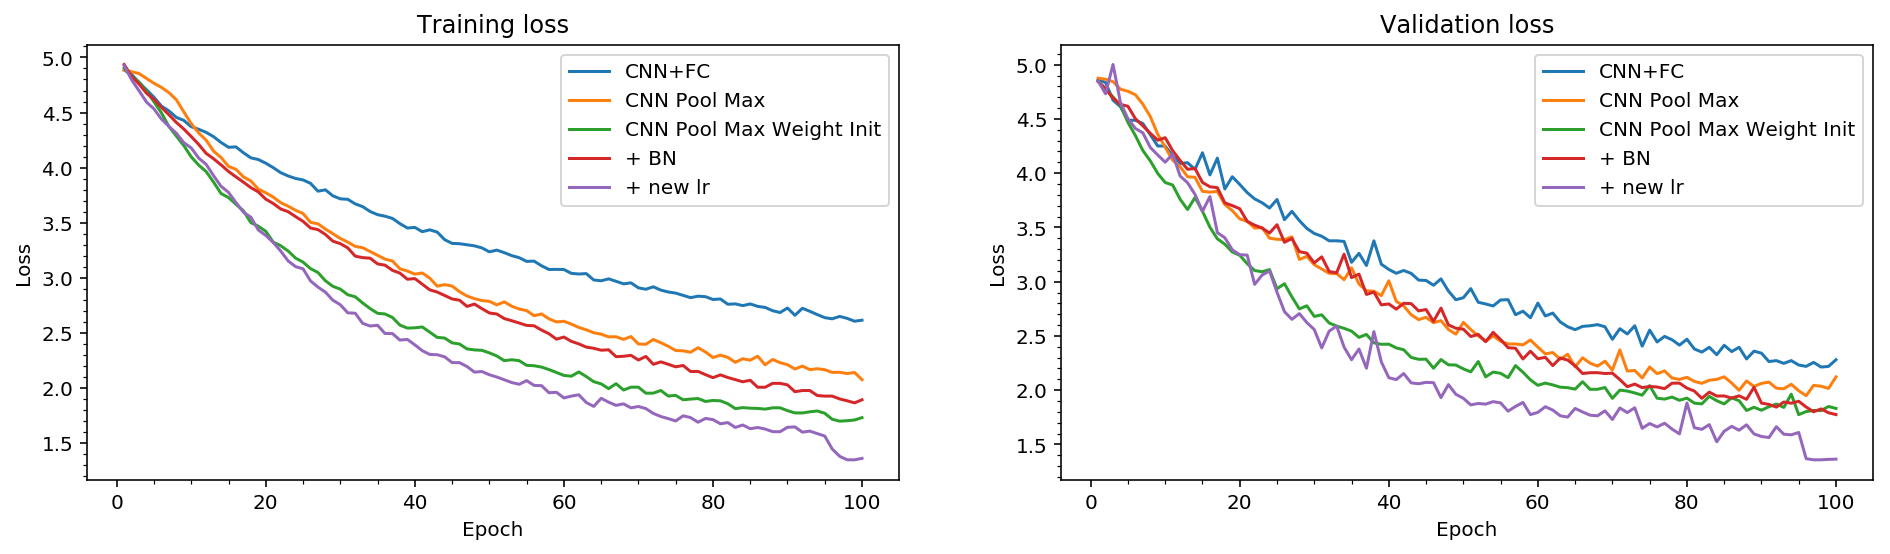

In [44]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt",
            f"./trained/model_5_bn_{n_epochs}.pt",
            f"./trained/model_5_bn_new_lr_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN Pool Max Weight Init","+ BN","+ new lr"]
show_loss_many_models(path_list, model_names = model_names)



Changing the learning rate made for a significant improvement, especially after the learning rate scheduler kicked in. We've come a long way from the first approach. There is one last thing that we could try...

In [45]:
learning_rate = learning_rates[2]

# Step 8: Residual connections
__[Residual networks](https://arxiv.org/abs/1512.03385)__ are an important stepping stone in the continued progress of convolutional nets. 

In [46]:
path_model = f"./trained/Net_BN_Res_1_{n_epochs}.pt"
from misc import Net_BN_Res # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_BN_Res(n_classes, depth_1 = depth_1)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean", do_lr_scheduling = True)

In [47]:
path_model = f"./trained/Net_BN_Res_2_{n_epochs}.pt"
from misc import Net_BN_Res_2 # need to do this everytime to not get the obj must be an instance error if I'm modifying misc.py
model = Net_BN_Res_2(n_classes, depth_1 = depth_1)
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean", do_lr_scheduling = True)

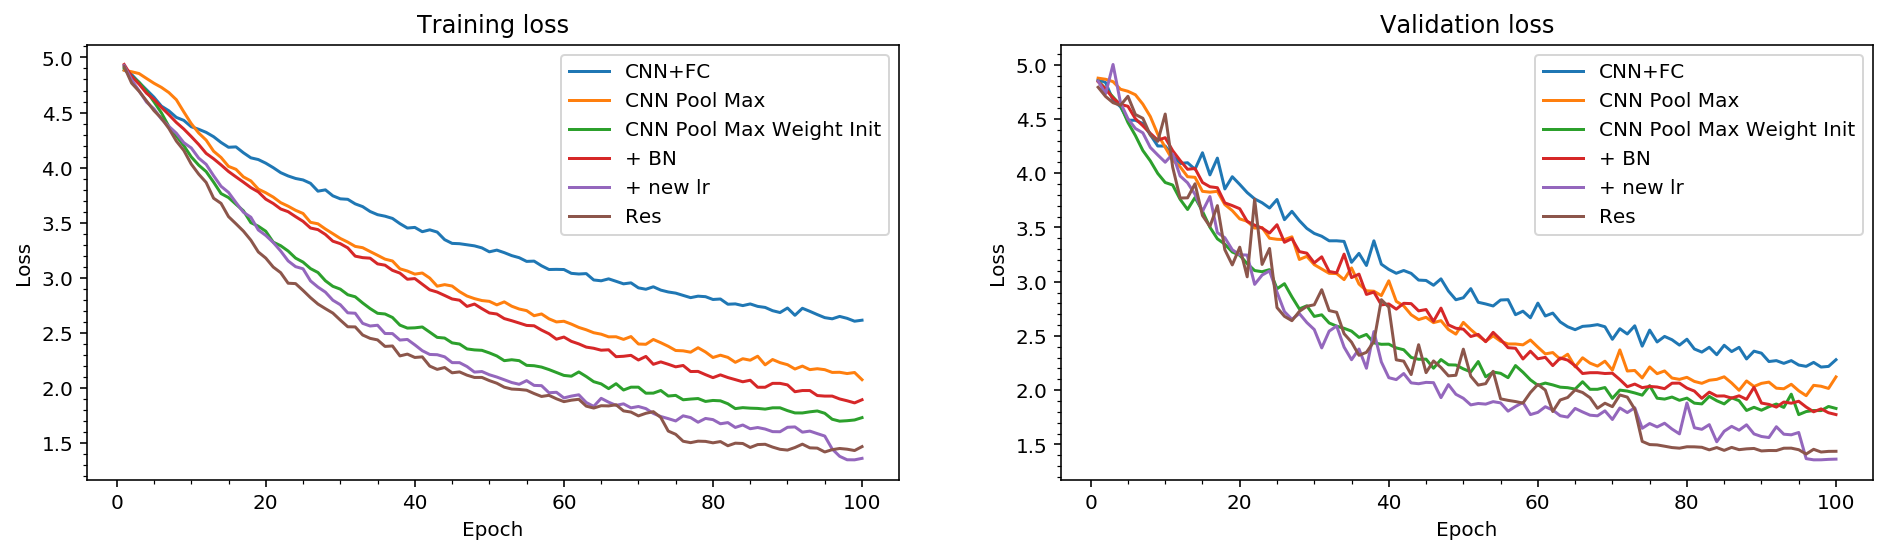

In [48]:
path_list = [f"./trained/model_2_aug_small_crops_5crop_mean_{n_epochs}.pt",
             f"./trained/model_3_pooling_max_{n_epochs}.pt",
            f"./trained/model_4_weight_init_{n_epochs}.pt",
            f"./trained/model_5_bn_{n_epochs}.pt",
            f"./trained/model_5_bn_new_lr_{n_epochs}.pt",
            f"./trained/Net_BN_Res_1_{n_epochs}.pt"]
model_names = ["CNN+FC","CNN Pool Max","CNN Pool Max Weight Init","+ BN","+ new lr","Res"]
show_loss_many_models(path_list, model_names = model_names)



In [49]:
# call test function    
path_model = f"./trained/model_5_bn_new_lr_{n_epochs}.pt"
model, train_loss, valid_loss = train_save_load_model(model,path_model,loaders,learning_rate,
                                                      n_epochs,device, fivecrop = True, mode = "mean", do_lr_scheduling = True)


In [50]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        bs, ncrops, c, h, w = data.size()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
        output = output.view(bs, ncrops, -1).mean(1)        
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_short_side_resize),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])
# We need to decrease the batch size to keep the same memory requirements. This means testing will be about 5x slower.
data, loaders, n_classes = create_data(image_folder = image_folder, transform_train = transform_train,
                                       transform_test = transform_test, 
                                       batch_size = 32, num_workers = num_workers, fivecrop = True)


test(loaders, model, nn.CrossEntropyLoss(), True)

Test Loss: 1.424797


Test Accuracy: 61% (514/836)
